In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

warnings.simplefilter("ignore", category=pd.errors.ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [18]:
tes_dir = parent_dir+'/data/V2-TEs/non_olap'
cotes_dir = parent_dir+'/data/V2-TEs/non_olap/cores1000/'

In [19]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [20]:
f = ['L1MCa' in i for i in COTEs]
# COTEs[f]

In [21]:
te_meta = pd.read_csv(parent_dir+'/analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTEs)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [22]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [23]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

-------

In [44]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'CoTE'})
    df['CoTE'] = df['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df.rename({i: i.split(':')[-1] for i in df.columns}, axis=1, inplace=True)
    df = df.set_index('CoTE')
    return df
def adjust_tables(df_gain, df_loss):
    gc = list(set(list(df_gain.columns)) - set(list(df_loss.columns)))
    for c in gc:
        df_loss[c]=1
    lc = list(set(list(df_loss.columns)) - set(list(df_gain.columns)))
    for c in gc:
        df_gain[c]=1
    
def lg_heatmap(c = 'chr8', orient='h', exp=11):
    df_gain = pd.read_csv(parent_dir+f'/analysis/experiment{exp}/gain/{c}__qval_n_hit.csv', index_col=False)
    df_gain = df_gain.rename(columns={'Unnamed: 0': 'CoTE'})
    df_gain['CoTE'] = df_gain['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df_gain.rename({i:i.split(':')[-1] for i in df_gain.columns}, axis=1, inplace=True)
    df_gain = df_gain.set_index('CoTE')
    
    df_loss = pd.read_csv(parent_dir+f'/analysis/experiment{exp}/loss/{c}__qval_n_hit.csv', index_col=False)
    df_loss = df_loss.rename(columns={'Unnamed: 0': 'CoTE'})
    df_loss['CoTE'] = df_loss['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df_loss.rename({i:i.split(':')[-1] for i in df_loss.columns}, axis=1, inplace=True)
    df_loss = df_loss.set_index('CoTE')
    adjust_tables(df_gain, df_loss)
    row_linkage = hierarchy.linkage(df_gain, method='average')
    col_linkage = hierarchy.linkage(df_gain.T, method='average')
    row_order = hierarchy.leaves_list(row_linkage)
    col_order = hierarchy.leaves_list(col_linkage)
    # plt.show()
    vmin = 0
    vmax = 1
    fig, axs = plt.subplots(2, 1, figsize=(70, 15), sharex=True) if orient=='h' else plt.subplots(1, 2, figsize=(15, 70))
    plt.suptitle(f'Copy Number Variation in different Cancer types vs Prescence/Abscence of CoTE in Mbp of {c}', fontsize=16, ha='center')
    sns.heatmap(df_gain.iloc[row_order, col_order] if orient=='v' else df_gain.T.iloc[col_order, row_order], square=False, ax=axs.flatten()[0], cbar=False, vmin=vmin, vmax=vmax)
    axs.flatten()[0].set_title('CNV Gain Locus', fontsize=16)
    sns.heatmap(df_loss.iloc[row_order, col_order] if orient=='v' else df_loss.T.iloc[col_order, row_order], square=False, ax=axs.flatten()[1], cbar=False, vmin=vmin, vmax=vmax)
    axs.flatten()[1].set_title('CNV Loss Locus', fontsize=16)
    for ax in axs.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(90)  # Rotate the x-tick labels to 45 degrees
            label.set_fontsize('x-small')  # Set the font size to 'x-small' or any appropriate size
        for label in ax.get_yticklabels():
            label.set_fontsize('x-small')  # Set the font size for y-tick labels
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(left=0.15)  # Adjust as needed
    plt.subplots_adjust(hspace=0.2)
    
    plt.show()
    # fig.savefig
    return df_gain, df_loss, fig
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e05]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e05]['TEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e05]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e05]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations
    
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[c] = ann
    return conditions, annotations

def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for c in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][c]])
        conditions[c] = np.array([int(i in idx) for i in chromosome_layer['index'][c]])
        annotations[c] = ann
    return conditions, annotations

In [25]:
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')

In [37]:
ind = IntData()
ind.add_layer("TEs", resolutions=[1e05], input=parent_dir+'/data/V2-TEs/non_olap', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs", resolutions=[1e05], input=parent_dir+'/data/V2-TEs/non_olap/cores1000', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CNVAR", resolutions=[1e05], input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal')
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'], resolutions=[1e05])

loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:11<00:00, 83.58it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap/cores1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:01<00:00, 308.42it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/CNVAR/segments/beds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:25<00:00,  3.58s/it]


In [45]:
ind.chr.add_filter('CoTE', Clustered_TEs, ['TEs'], resolutions=[1e05])
ind.chr.add_filter('te_family', TE_family, ['TEs'], resolutions=[1e05])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'], resolutions=[1e05])

In [46]:
def cdriver_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con = {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for chr in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][chr]
        conditions[chr] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[chr] = ann
    return conditions, annotations

In [29]:
chroms = ca.info.CHROMOSOMES['names'][:-1]

figure saved at /Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/figure.png


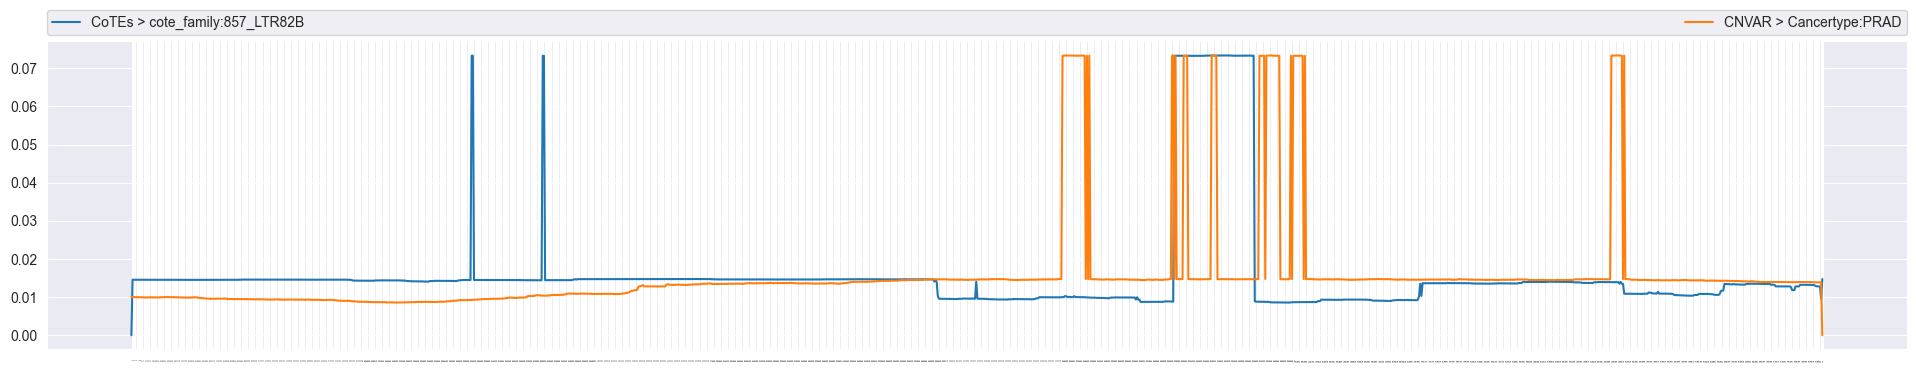

In [57]:
c = 'chr8'
ct = 'PRAD'
df = pd.read_csv(parent_dir+f'/analysis/experiment20/gain/{c}__qval_n_hit.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
q_ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}')

df = pd.read_csv(parent_dir+f'/analysis/experiment20/gain/{c}__n_hits.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}', ascending=False)
families = [i.split('>')[-1] for i in q_ct_df.loc[q_ct_df.values<=0.031].index.values]
ca.pl.match_layers(ind.chr, ['CoTEs', 'CNVAR'], chrom=c, groups={'CNVAR':{'Cancertype':[ct]}, 
                                                                    'CoTEs':{'cote_family':families[2]}}, 
                                               qnormalize=True,
                                               normalize=True,
                                               aggregation='sum',
                                               save_fig=True, 
                                               resolution=1e05,
                                               path='/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/')

In [69]:
d = ind.chr.get_layer('TEs', resolution=1e05, chrom='chr8')['data']
x = ind.chr.get_layer('TEs', resolution=1e05, chrom='chr8')['index']

In [73]:
res = find_bed_files_covering_region(('chr8', 127738251, 127742951), tes_dir)

In [75]:
res

['1141_MIR_Merged.bed', '1140_MIRb_Merged.bed', '90_AluSc5_Merged.bed']

In [72]:
def find_bed_files_covering_region(region, directory_path):
    # Unpack the region into chromosome, start, and end
    chrom, start, end = region
    start, end = int(start), int(end)

    # List to store the names of matching BED files
    matching_files = []

    # Iterate over all files in the given directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".bed"):
            file_path = os.path.join(directory_path, filename)

            # Read the BED file
            try:
                bed_data = pd.read_csv(file_path, sep="\t", header=None, usecols=[0, 1, 2])
                # Check if any row in the BED file covers the region
                for _, row in bed_data.iterrows():
                    if row[0] == chrom and start <= row[1] and end >= row[2]:
                        matching_files.append(filename)
                        break
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    return matching_files

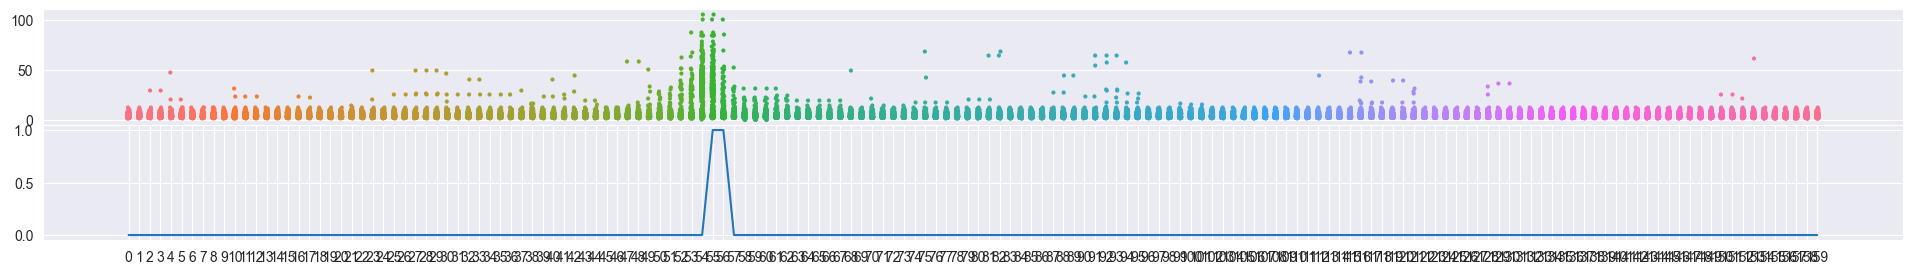

In [352]:
fig, axs = plt.subplots(2, 1, figsize=(24, 3), sharex=True)
sns.stripplot(pd.DataFrame(f),size=3, ax=axs[0])#, showfliers=False)
sns.lineplot(j.flatten())
plt.subplots_adjust(hspace=0)  # Adjust the space between the plots
plt.show()

In [308]:
tf = families[2]
g = ind.chr.get_layer('CoTEs', chrom=c, groups={'cote_family':tf})
j = g['cote_family'][tf]['data']

figure saved at /Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/figure.png


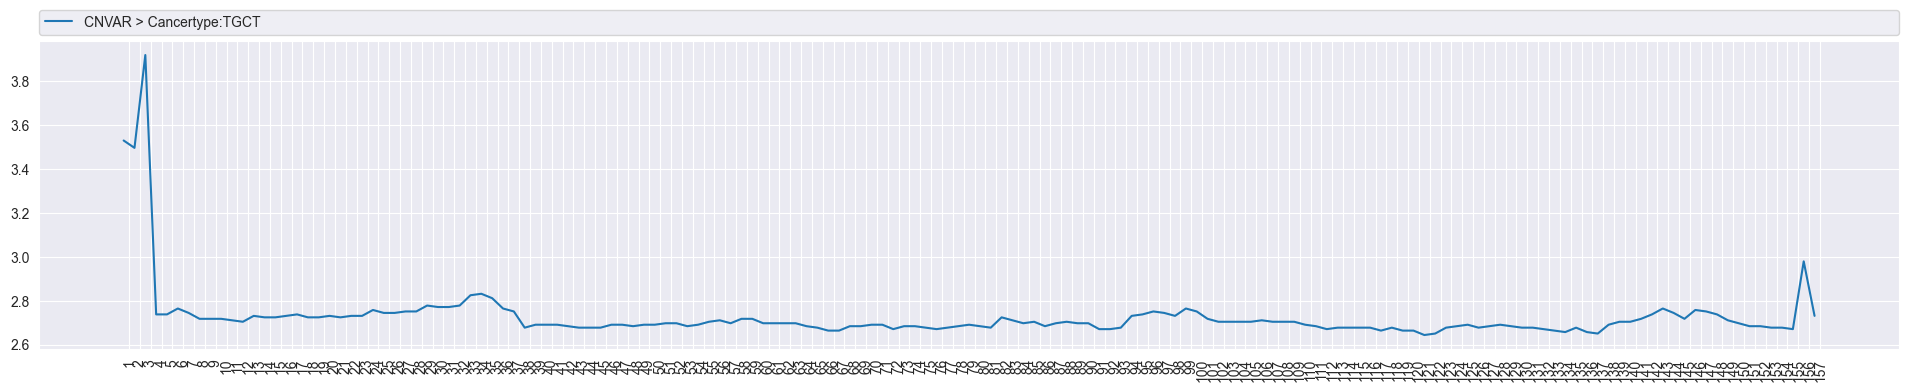

In [252]:
ca.pl.match_layers(ind.chr, ['CNVAR'], chrom='chrX', groups={'CNVAR':{'Cancertype':['TGCT']}},                   
                   save_fig=True, 
                   path='/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/', 
                   normal_y=False, 
                   aggregation='mean')

In [214]:
df = pd.read_csv(parent_dir+f'/analysis/experiment16/loss/{c}__qval_n_hit.csv', index_col=False)


['1009_MER4D1']


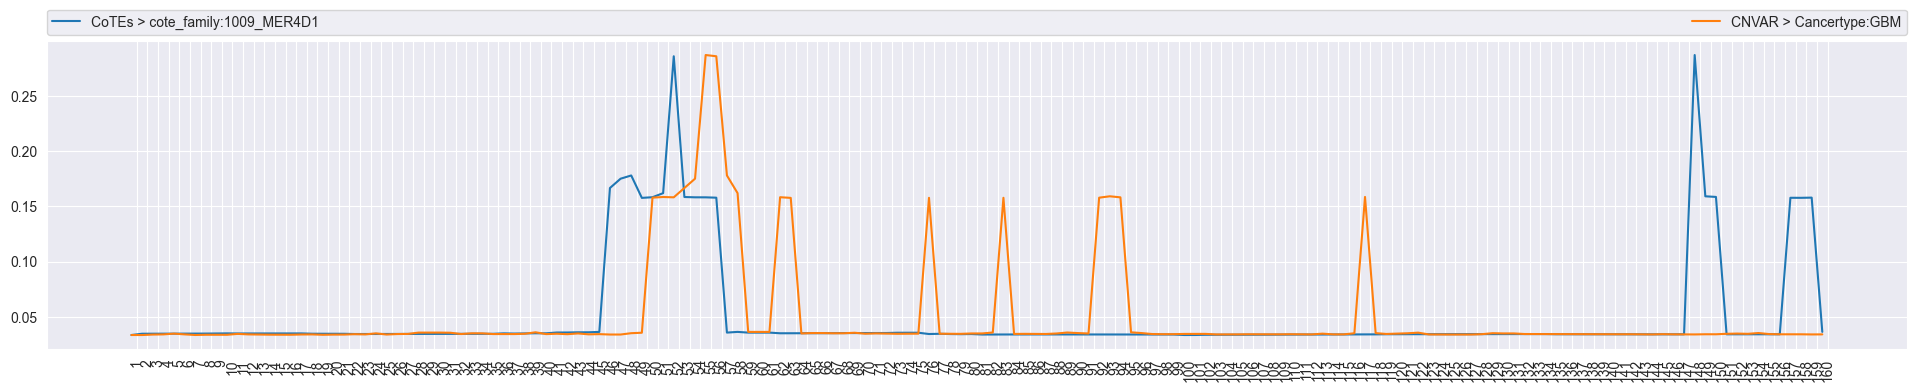

In [132]:
c = 'chr7'
ct = 'GBM'
df = pd.read_csv(parent_dir+f'/analysis/experiment16/loss/{c}__qval_n_hit.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
q_ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}')

df = pd.read_csv(parent_dir+f'/analysis/experiment16/loss/{c}__n_hits.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}', ascending=False)

families = [i.split('>')[-1] for i in q_ct_df.loc[q_ct_df.values<=0.031].index.values]
print(families)
ca.pl.match_layers(ind.chr, ['CoTEs', 'CNVAR'], chrom=c, groups={'CNVAR':{'Cancertype':[ct]}, 
                                                                    'CoTEs':{'cote_family':families}})

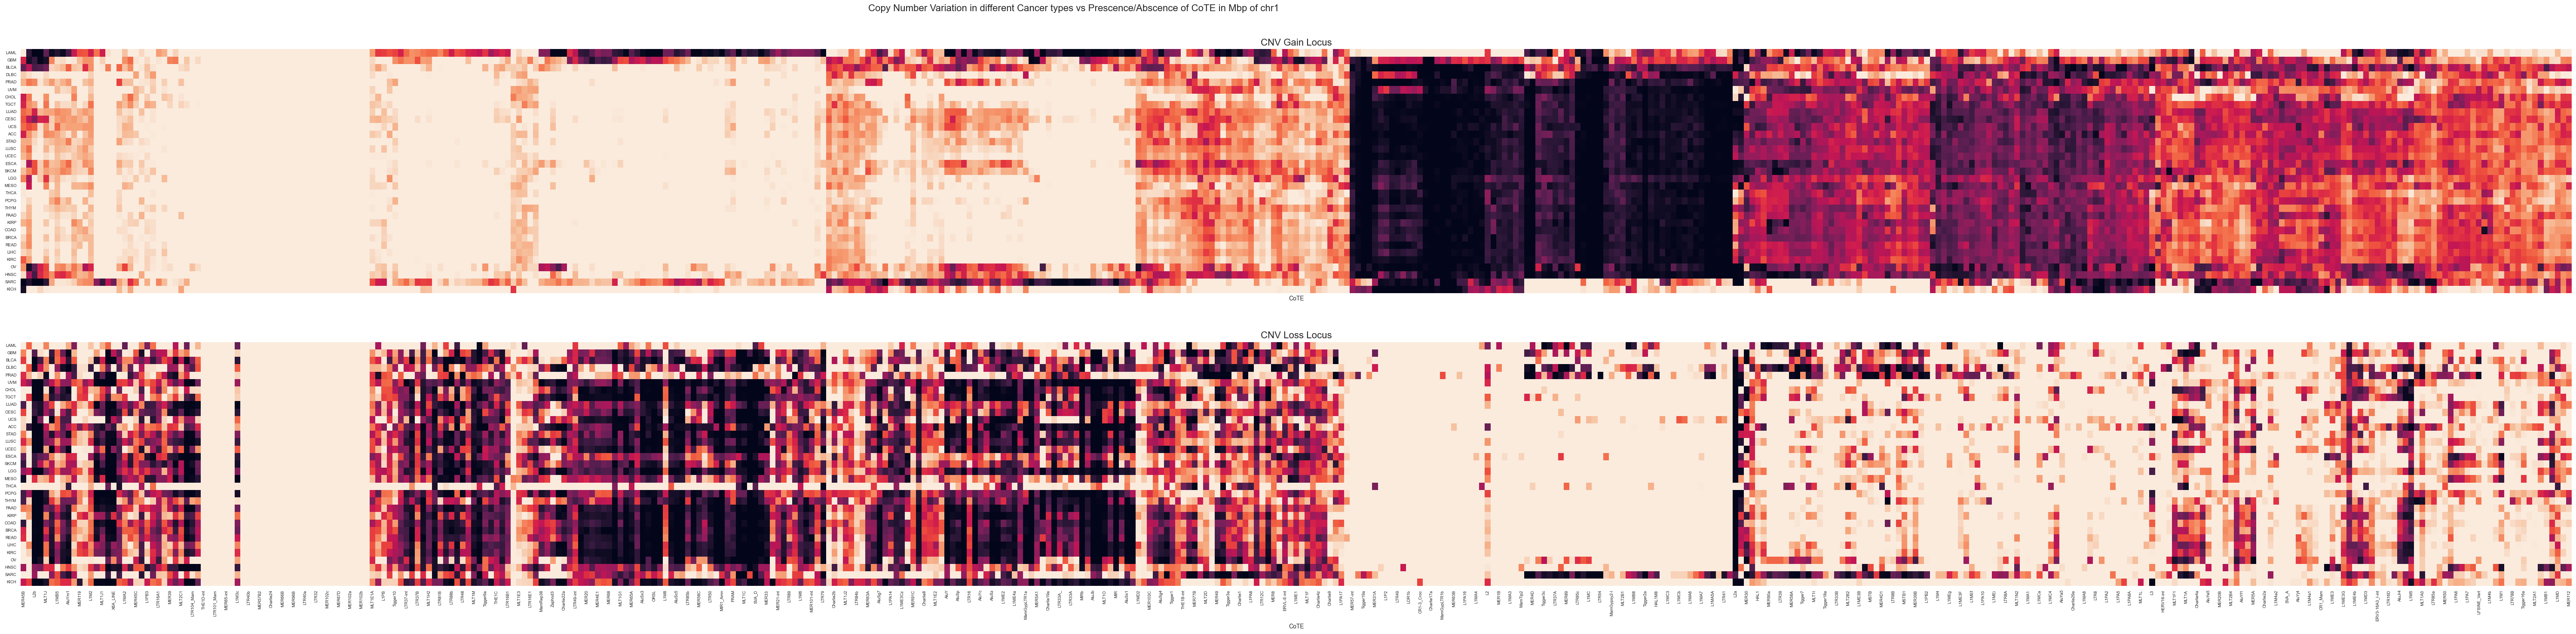

In [26]:
df_gain, df_loss, fig = lg_heatmap('chr1', 'h', 16)

<Axes: ylabel='GBM'>

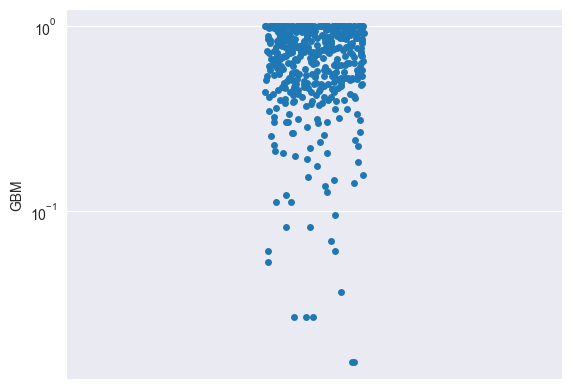

In [53]:
plt.yscale('log')
sns.stripplot(df_gain['GBM'])

In [243]:
c = 'chr17'
val = pd.read_csv(parent_dir+f'/analysis/experiment16/gain/{c}__n_hits.csv', index_col=False)
val = val.rename(columns={'Unnamed: 0': 'CoTE'})
val['CoTE'] = val['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
val = val.set_index('CoTE')
qval = pd.read_csv(parent_dir+f'/analysis/experiment16/gain/{c}__qval_n_hit.csv', index_col=False)
qval = qval.rename(columns={'Unnamed: 0': 'CoTE'})
qval['CoTE'] = qval['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
qval = qval.set_index('CoTE')

In [245]:
df = qval[['CNVAR;Cancertype:BRCA']]
bf = val[['CNVAR;Cancertype:BRCA']]

In [246]:
total = df.join(bf, lsuffix='-qval', rsuffix= '-val', )

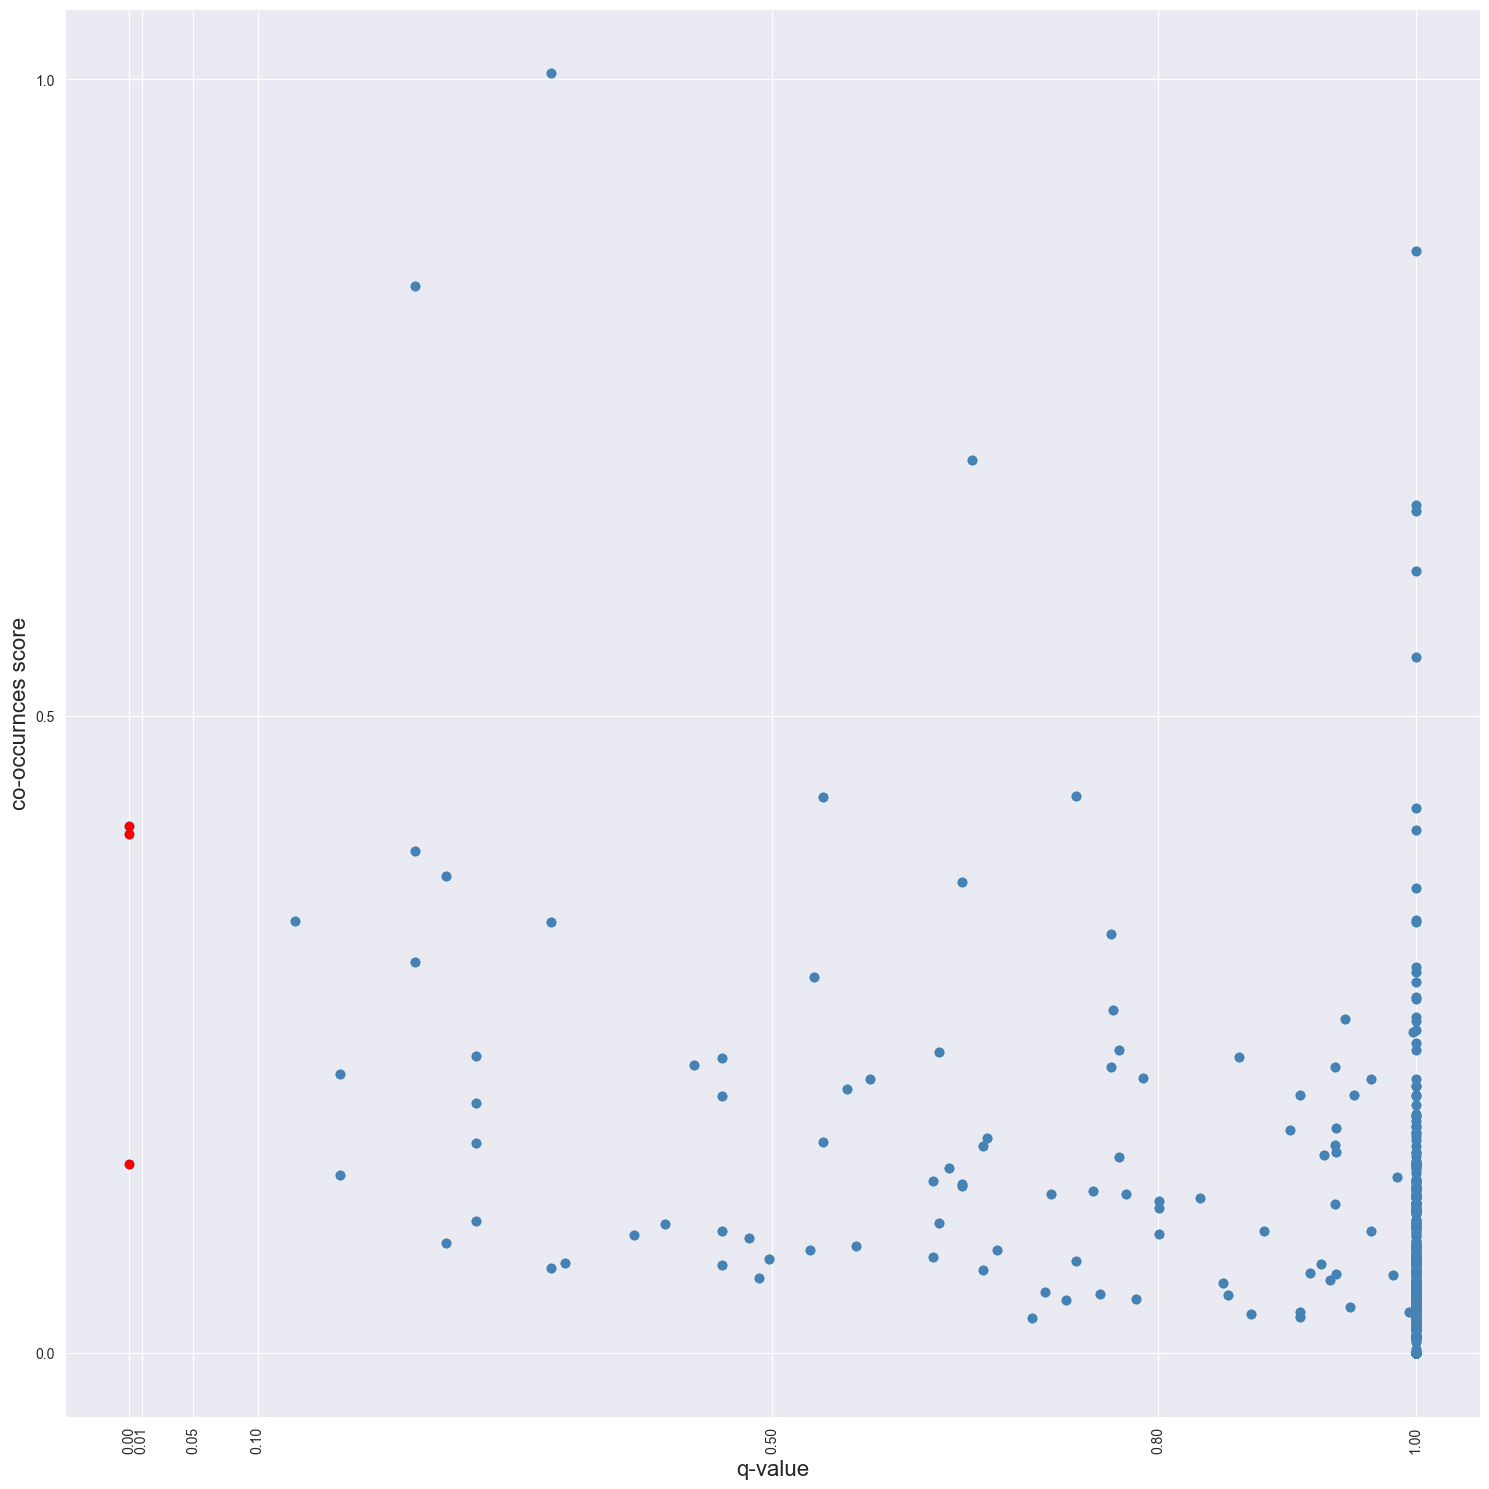

In [247]:
fig =plt.figure(figsize=(15, 15))
plt.xticks([0, 0.01, 0.05, 0.1, 0.5, 0.8, 1], rotation=90)
plt.yticks(np.arange(0, 5, 0.5))
plt.xlabel('q-value', fontsize=16)
plt.ylabel('co-occurnces score', fontsize=16)
plt.scatter(total.values[:,0], total.values[:, 1])
for x, y in zip(total.values[:,0], total.values[:, 1]):
    color = 'red' if x < 0.01 else 'steelblue'  # Red if y < 0.01, otherwise blue
    plt.scatter(x, y, color=color)
plt.tight_layout()
fig.savefig('scatter.png')

In [248]:
total.sort_values(['CNVAR;Cancertype:BRCA-qval', 'CNVAR;Cancertype:BRCA-val'], ascending=False).tail(10)

,CNVAR;Cancertype:BRCA-qval,CNVAR;Cancertype:BRCA-val
CoTE,,
L3b,0.246412,0.086368
Tigger19a,0.222455,0.837479
MER131,0.222455,0.393817
Charlie19a,0.222455,0.306596
MER45A,0.164275,0.218817
Charlie15b,0.164275,0.139703
FAM,0.128871,0.339097
MER47A,0.000000,0.413198
Tigger7,0.000000,0.407241


In [234]:
d = ind.chr.get_layer('CNVAR', chrom='chr7', groups={'Cancertype':['GBM']})['Cancertype']['GBM']['data']


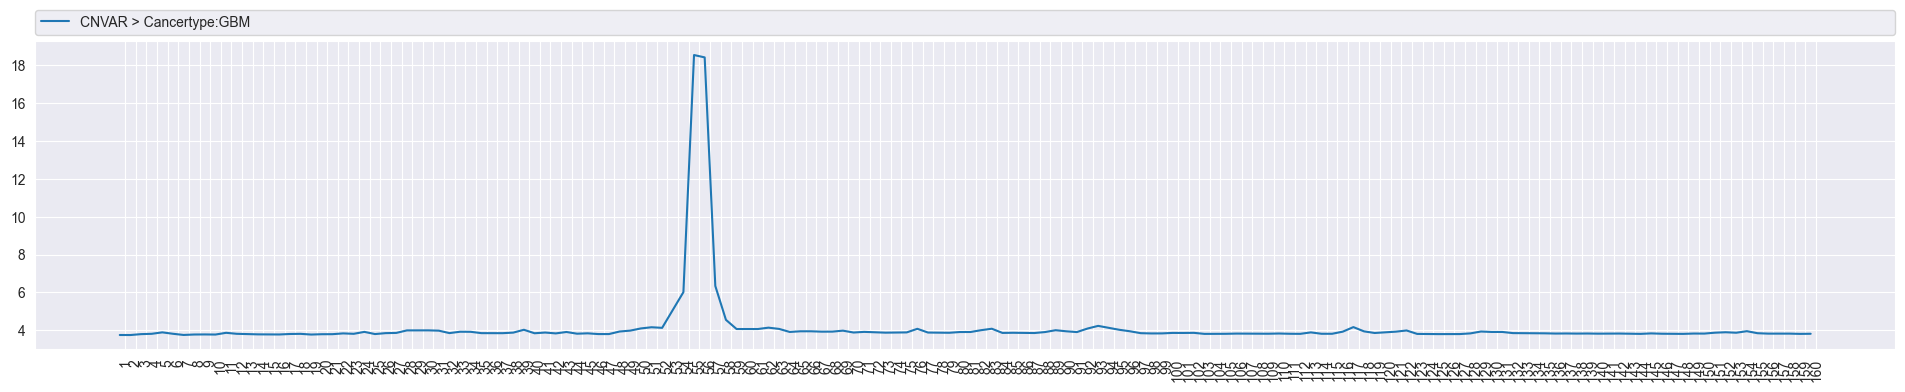

In [227]:
ca.pl.match_layers(ind.chr, ['CNVAR'], chrom='chr7', groups={'CNVAR':{'Cancertype':['GBM']}}, normal_y=False, aggregation='mean')

In [14]:
ca.pl.match_layers(ind.chr, ['CoTEs'], chrom='chr7', groups={ 'CoTEs':{'cote_family':['1009_MER4D1']}}, normal_y=False, aggregation='mean')

NameError: name 'ind' is not defined

In [12]:
from chromATAC.pl import StackPlot

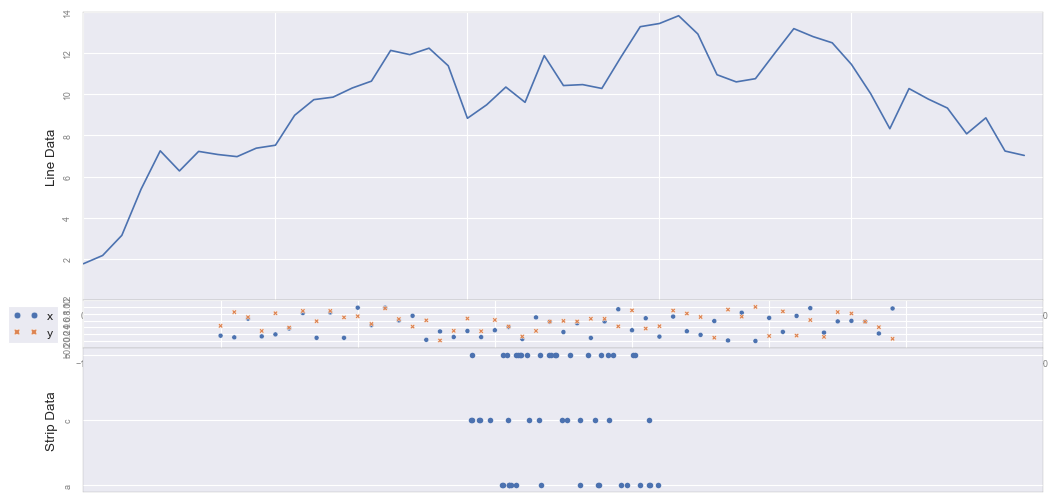

In [216]:
# Generate sample data
np.random.seed(0)
line_data = pd.Series(np.random.randn(50).cumsum(), name="Line Data")
scatter_data = pd.DataFrame({'x': np.random.rand(50), 'y': np.random.rand(50)})
strip_data = pd.Series(np.random.choice(['a', 'b', 'c'], 50), name="Strip Data")

# Create a StackPlot and add tracks
spl = StackPlot(figsize=(15, 6), show_borders=True)
line_track = spl.add_track((0.4, 1), 'line plot')
line_track.lineplot(data=line_data)

scatter_track = spl.add_track((0.3, 0.4), 'scatter plot')
scatter_track.scatterplot(data=scatter_data)

strip_track = spl.add_track((0.0, 0.3), 'strip plot')
strip_track.stripplot(data=strip_data)

# Render the StackPlot
spl.render(show_borders=True,
           border_color='grey', 
           border_width=.2, 
           legend_position='left', 
           ticks_fontsize=8, 
           ticks_color='grey', 
           y_ticks_rotation=90)

In [353]:

# Generate sample data
np.random.seed(0)
line_data = pd.Series(np.random.randn(50).cumsum(), name="Line Data")
scatter_data = pd.DataFrame({'x': np.random.rand(50), 'y': np.random.rand(50)})
strip_data = pd.Series(np.random.choice(['a', 'b', 'c'], 50), name="Strip Data")

# Create a StackPlot and add tracks
spl = StackPlot(figsize=(12, 6), show_borders=True)
line_track = spl.add_track((0.6, 1.0), 'line plot')
line_track.lineplot(data=line_data)

scatter_track = spl.add_track((0.3, 0.6), 'scatter plot')
scatter_track.scatterplot(data=scatter_data)

strip_track = spl.add_track((0.0, 0.3), 'strip plot')
strip_track.stripplot(data=strip_data)

# Render the StackPlot
spl.render()



NameError: name 'StackPlot' is not defined